In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from copy import copy, deepcopy
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score, roc_curve, make_scorer, precision_score, recall_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from collections import Counter

In [27]:
with open('statcast_full_clean.pkl', 'rb') as p:
    data = pickle.load(p)

In [28]:
data.head()

,game_date,game_year,home_team,away_team,def_team,at_bat_number,events,launch_angle,launch_speed,spray_angle,...,cf_ht,rf_ht,lf,lc,cf,rc,rf,hit_rate_wk,hit_rate_mo,hit
0,2015-04-06,2015,ARI,SF,ARI,1,field_out,14.2,95.1,-17.190065,...,25,8,330,376,407,376,335,0.000000,0.000000,0
1,2015-04-06,2015,ARI,SF,ARI,2,single,18.0,69.3,-11.669137,...,25,8,330,376,407,376,335,0.000000,0.000000,1
2,2015-04-06,2015,ARI,SF,ARI,3,double,1.0,95.4,33.561451,...,25,8,330,376,407,376,335,0.500000,0.500000,1
3,2015-04-06,2015,ARI,SF,ARI,5,field_out,32.1,102.3,0.910465,...,25,8,330,376,407,376,335,0.666667,0.666667,0
4,2015-04-06,2015,ARI,SF,ARI,10,field_out,-15.7,88.5,6.054393,...,25,8,330,376,407,376,335,0.500000,0.500000,0


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630221 entries, 0 to 630220
Data columns (total 23 columns):
game_date        630221 non-null object
game_year        630221 non-null int64
home_team        630221 non-null object
away_team        630221 non-null object
def_team         630221 non-null object
at_bat_number    630221 non-null int64
events           630221 non-null object
launch_angle     630221 non-null float64
launch_speed     630221 non-null float64
spray_angle      630221 non-null float64
fair             630221 non-null float64
foul             630221 non-null float64
lf_ht            630221 non-null int64
cf_ht            630221 non-null int64
rf_ht            630221 non-null int64
lf               630221 non-null int64
lc               630221 non-null int64
cf               630221 non-null int64
rc               630221 non-null int64
rf               630221 non-null int64
hit_rate_wk      630221 non-null float64
hit_rate_mo      630221 non-null float64
hit         

In [30]:
data_train = data[data['game_year'] < 2019]
data_test = data[data['game_year'] == 2019]

In [31]:
# keep 'hit' in X for now just for EDA purposes
X_train = data_train.drop(columns=['game_date', 'game_year', 'home_team', 'away_team', 'def_team', 'at_bat_number', 'events'])
X_test = data_test.drop(columns=['game_date', 'game_year', 'home_team', 'away_team', 'def_team', 'at_bat_number', 'events'])
y_train = data_train['hit']
y_test = data_test['hit']

In [32]:
print(X_train.shape)
print(X_test.shape)

(506346, 16)
(123875, 16)


In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

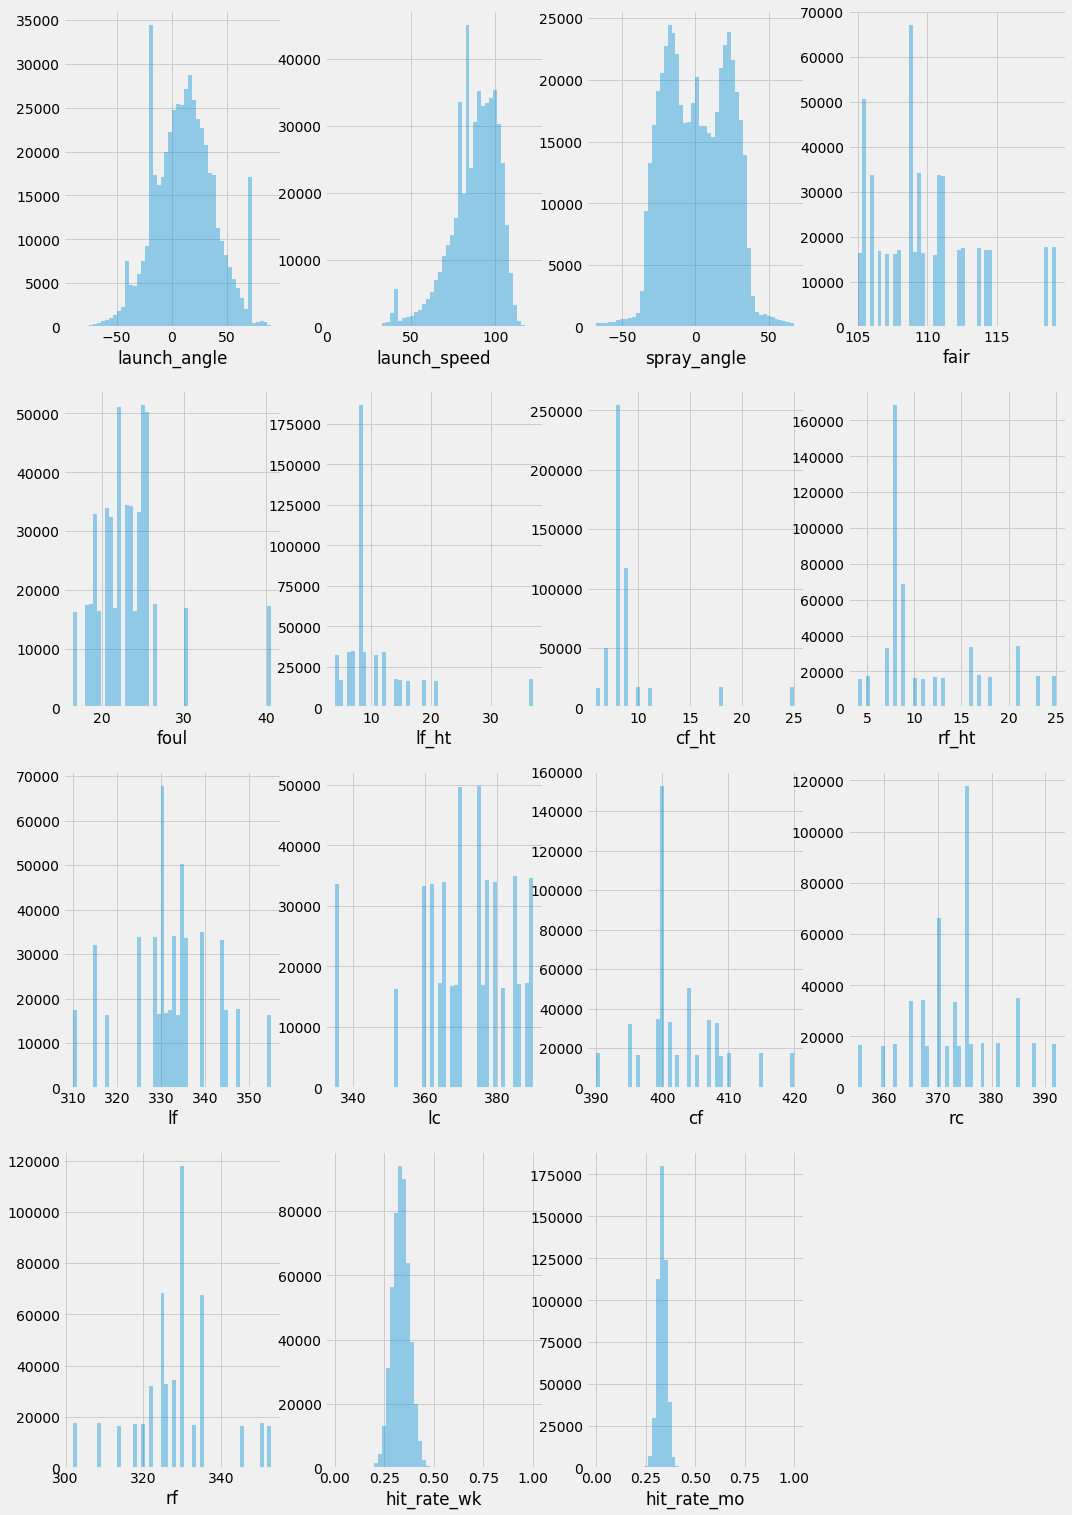

In [34]:
cols = X_train.columns
plt.figure(figsize=(16,25))
for i in range(len(cols)-1):
    plt.subplot(4, 4, i+1)
    sns.distplot(X_train[cols[i]],kde=False)

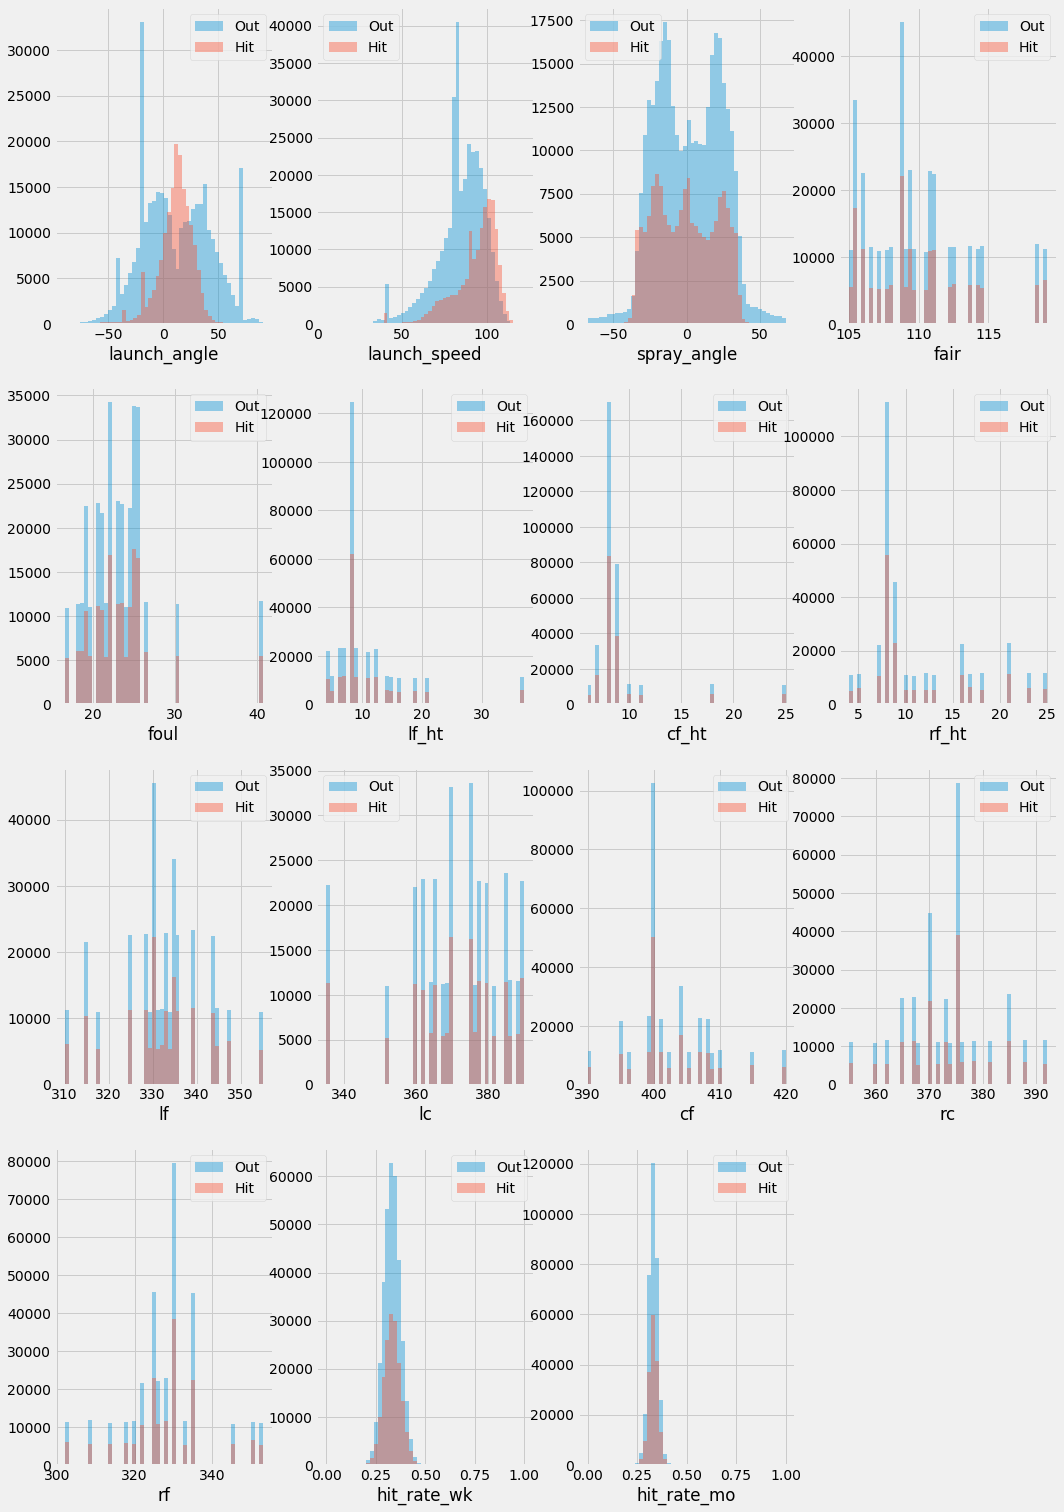

In [35]:
plt.figure(figsize=(16,25))
for i in range(len(cols)-1):
    plt.subplot(4, 4, i+1)
    sns.distplot(X_train.groupby('hit')[cols[i]].get_group(0), kde=False, label='Out');
    sns.distplot(X_train.groupby('hit')[cols[i]].get_group(1), kde= False, label='Hit');
    plt.legend();

In [36]:
X_train = X_train.drop(columns='hit')
X_test = X_test.drop(columns='hit')

In [37]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [38]:
# pipe = Pipeline(steps=[('sc', sc), ('logistic', LogisticRegression(class_weight='balanced', random_state=42, solver='saga'))])

In [39]:
# params = {
#         'logistic__penalty': ['l1', 'l2'],
#         'logistic__C': np.logspace(-3, 3, 7)
#     }
# grid_search = GridSearchCV(estimator = pipe, param_grid = params, scoring='roc_auc', cv = skf, verbose = 2)

In [40]:
# grid_search.fit(X_train, y_train)

In [41]:
# best_grid = grid_search.best_estimator_
# best_grid

In [42]:
# best_grid.fit(X_train, y_train)
# best_grid.predict_proba(X_test)

In [43]:
# fpr, tpr, _ = roc_curve(y_test, best_grid.predict_proba(X_test)[:,1])
# plt.plot(fpr, tpr)

In [44]:
models = {
    'LogisticRegression': Pipeline(steps=[('sc', StandardScaler()), ('logistic', LogisticRegression(class_weight='balanced', random_state=42, solver='saga'))]),
    'LogisticRegression_SMOTE': Pipeline(steps=[('sc', StandardScaler()), ('logistic', LogisticRegression(random_state=42, solver='saga'))]),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'RandomForest_SMOTE': RandomForestClassifier(random_state=42, n_jobs=-1),
    'GradientBoosting_ES': GradientBoostingClassifier(max_features=15, max_depth=10, random_state=42, n_iter_no_change=5, tol=.01)
}

In [45]:
param_grids = {
    'LogisticRegression': {
        'logistic__penalty': ['l1', 'l2'],
        'logistic__C': np.logspace(-3, 3, 7)
    },
    'RandomForest': {
        'max_features': [15],
        'max_depth': np.arange(2, 11, 1)
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [.01, .1, .5, 1]
    }
}

In [46]:
model_results = {}
for name, model in models.items():
    
    use_grid = [k for k in param_grids.keys() if k in name][0]
    grid_search = GridSearchCV(estimator = model, param_grid = param_grids[use_grid], scoring='roc_auc', cv = skf, verbose = 2, return_train_score=True)
    
    if 'SMOTE' in name:
        X_res, y_res = SMOTE(random_state=42).fit_sample(X_train, y_train)
        grid_search.fit(X_res, y_res)
    else:
        grid_search.fit(X_train, y_train)
    test_score = grid_search.best_score_
    best_test_idx = np.argmax(grid_search.cv_results_['mean_test_score'])
    train_score = grid_search.cv_results_['mean_train_score'][best_test_idx]
    
    best_grid = grid_search.best_estimator_
    best_grid.fit(X_train, y_train)
    feat_imp = best_grid.named_steps['logistic'].coef_ if 'LogisticRegression' in name else best_grid.feature_importances_
    
    y_pred = best_grid.predict(X_test)
    if 'LogisticRegression' in name:
        fpr, tpr, thresholds = roc_curve(y_test, best_grid.predict_proba(X_test)[:,1])
    else:
        fpr, tpr, thresholds = roc_curve(y_test, best_grid.predict_proba(X_test)[:,1])
    
    model_results[name] = [grid_search.best_params_, grid_search.best_estimator_, train_score, test_score, feat_imp, fpr, tpr]
    

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.5s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.7s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.9s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   3.9s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   4.2s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   3.8s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   4.0s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   3.3s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .

[CV] .......... logistic__C=100.0, logistic__penalty=l2, total=   4.0s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   3.9s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   4.4s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   4.3s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   4.3s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   3.4s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l2, total=   3.0s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  4.9min finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   5.0s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   4.9s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   6.6s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   5.3s
[CV] logistic__C=0.001, logistic__penalty=l1 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l1, total=   6.2s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   5.5s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   4.6s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .......... logistic__C=0.001, logistic__penalty=l2, total=   5.4s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV] .

[CV] .......... logistic__C=100.0, logistic__penalty=l2, total=   4.5s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   4.9s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   5.4s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   6.1s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   6.5s
[CV] logistic__C=1000.0, logistic__penalty=l1 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l1, total=   6.4s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] ......... logistic__C=1000.0, logistic__penalty=l2, total=   5.9s
[CV] logistic__C=1000.0, logistic__penalty=l2 ........................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  7.1min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=2, max_features=15, total=  13.2s
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV] ..................... max_depth=2, max_features=15, total=  13.0s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  12.8s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  14.0s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  14.1s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  18.0s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  17.6s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  17.6s
[CV] max_depth=3, max_features=15 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 28.9min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=2, max_features=15, total=  19.8s
[CV] max_depth=2, max_features=15 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s remaining:    0.0s


[CV] ..................... max_depth=2, max_features=15, total=  22.9s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  27.6s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  21.3s
[CV] max_depth=2, max_features=15 ....................................
[CV] ..................... max_depth=2, max_features=15, total=  21.4s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  30.2s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  31.8s
[CV] max_depth=3, max_features=15 ....................................
[CV] ..................... max_depth=3, max_features=15, total=  29.5s
[CV] max_depth=3, max_features=15 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 47.2min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.5min
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.2min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.4min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.2min
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total= 2.3min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total= 4.9min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total= 4.7min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] ............. learning_rate=0.01, n_estimators=100, total= 4.9min
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] .

[CV] ................ learning_rate=1, n_estimators=200, total=  19.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 98.3min finished


In [47]:
df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Best_Params', 'Best_Estimator', 'Train', 'Test', 'Feature_Imp','FPR', 'TPR'])
df

,Best_Params,Best_Estimator,Train,Test,Feature_Imp,FPR,TPR
LogisticRegression,"{'logistic__C': 0.001, 'logistic__penalty': 'l1'}","(StandardScaler(), LogisticRegression(C=0.001,...",0.704261,0.704247,"[[-0.12649592384022457, 0.6874588063691827, -0...","[0.0, 0.0, 0.0, 1.221433718899244e-05, 1.22143...","[0.0, 2.3807256451766497e-05, 9.52290258070659..."
LogisticRegression_SMOTE,"{'logistic__C': 0.001, 'logistic__penalty': 'l1'}","(StandardScaler(), LogisticRegression(C=0.001,...",0.705159,0.705135,"[[-0.10901664036181369, 0.7466836231885078, -0...","[0.0, 0.0, 0.0, 2.442867437798488e-05, 2.44286...","[0.0, 2.3807256451766497e-05, 0.00014284353871..."
RandomForest,"{'max_depth': 10, 'max_features': 15}","(DecisionTreeClassifier(max_depth=10, max_feat...",0.915595,0.908117,"[0.4395203532731239, 0.4247605646193089, 0.122...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.442...","[0.0, 0.004904294829063898, 0.0202837824969050..."
RandomForest_SMOTE,"{'max_depth': 10, 'max_features': 15}","(DecisionTreeClassifier(max_depth=10, max_feat...",0.917302,0.912149,"[0.4276538782517962, 0.4265667067748415, 0.131...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.004904294829063898, 0.0202837824969050..."
GradientBoosting_ES,"{'learning_rate': 0.1, 'n_estimators': 50}",([DecisionTreeRegressor(criterion='friedman_ms...,0.932218,0.916568,"[0.40467612293844685, 0.40096515906987756, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.3807256451766497e-05, 4.76145129035329..."


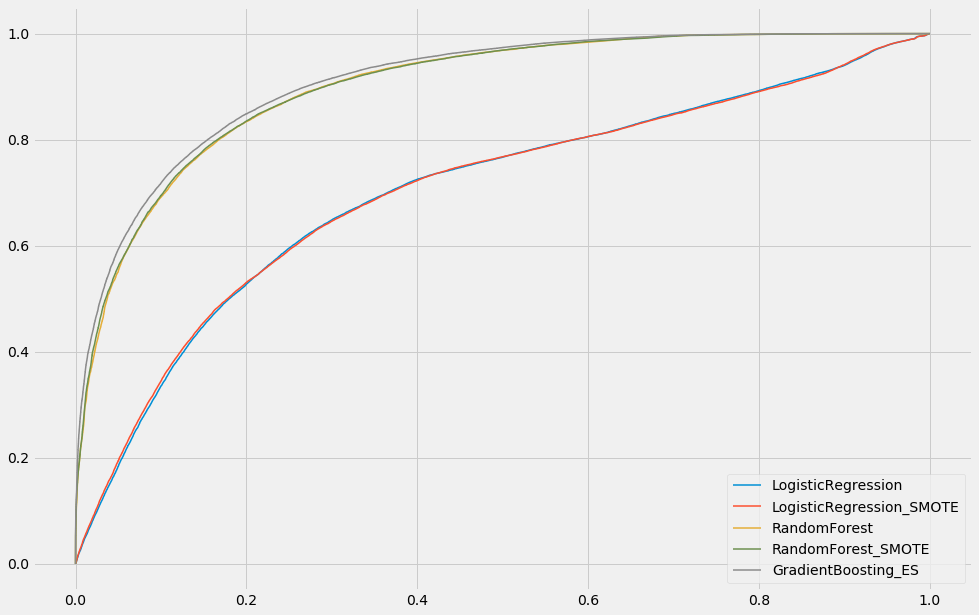

In [48]:
plt.figure(figsize=(15,10))
for i,row in df.iterrows():
    plt.plot(row['FPR'], row['TPR'], lw=1.5, label=i)
plt.legend()

In [49]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [50]:
gb_depth = GradientBoostingClassifier(random_state=42, n_iter_no_change=5, tol=.01)
depth_grid = {
    'max_depth': np.arange(1, 21, 1)
}
depth_search = GridSearchCV(estimator = gb_depth, param_grid = depth_grid, scoring=ftwo_scorer, cv = skf, verbose = 2, return_train_score=True)

In [51]:
depth_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=1, total=  18.0s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s


[CV] ...................................... max_depth=1, total=  19.2s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=  15.6s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=  17.7s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=1, total=  19.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  27.6s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  31.5s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=  25.4s
[CV] max_depth=2 .....................................................
[CV] .

[CV] ..................................... max_depth=12, total= 2.0min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 2.2min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 2.2min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 1.9min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 1.8min
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total= 1.8min
[CV] max_depth=14 ....................................................
[CV] ..................................... max_depth=14, total= 2.2min
[CV] max_depth=14 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 219.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(n_iter_no_change=5,
                                                  random_state=42, tol=0.01),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [52]:
depth_train = depth_search.cv_results_['mean_train_score']
depth_test = depth_search.cv_results_['mean_test_score']

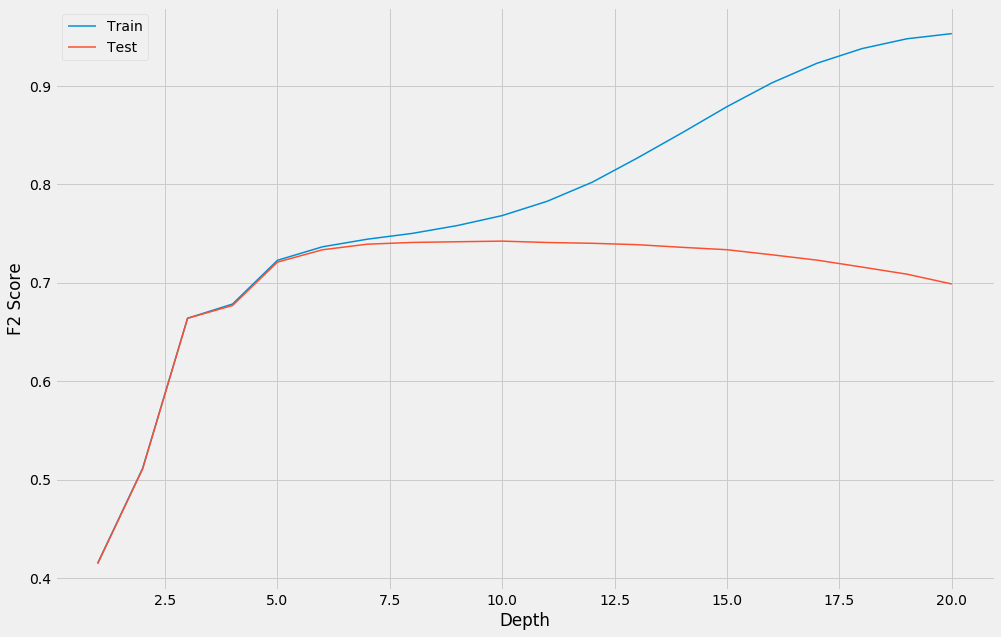

In [58]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,21,1), depth_train, lw=1.5, label='Train')
plt.plot(np.arange(1,21,1), depth_test, lw=1.5, label='Test')
plt.xlabel('Depth')
plt.ylabel('F2 Score')
plt.legend()

In [60]:
depth_search.best_params_

{'max_depth': 10}

In [64]:
gb_feat = GradientBoostingClassifier(max_depth=10, random_state=42, n_iter_no_change=5, tol=.01)
feat_grid = {
    'max_features': np.arange(4, 16, 1)
}
feat_search = GridSearchCV(estimator = gb_feat, param_grid = feat_grid, scoring=ftwo_scorer, cv = skf, verbose = 2, return_train_score=True)

In [65]:
feat_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_features=4 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... max_features=4, total=  40.3s
[CV] max_features=4 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s


[CV] ................................... max_features=4, total=  41.4s
[CV] max_features=4 ..................................................
[CV] ................................... max_features=4, total=  44.2s
[CV] max_features=4 ..................................................
[CV] ................................... max_features=4, total=  44.7s
[CV] max_features=4 ..................................................
[CV] ................................... max_features=4, total=  40.9s
[CV] max_features=5 ..................................................
[CV] ................................... max_features=5, total=  53.3s
[CV] max_features=5 ..................................................
[CV] ................................... max_features=5, total=  57.2s
[CV] max_features=5 ..................................................
[CV] ................................... max_features=5, total=  42.6s
[CV] max_features=5 ..................................................
[CV] .

[CV] .................................. max_features=15, total= 1.4min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 65.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_depth=10,
                                                  n_iter_no_change=5,
                                                  random_state=42, tol=0.01),
             param_grid={'max_features': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [66]:
feat_train = feat_search.cv_results_['mean_train_score']
feat_test = feat_search.cv_results_['mean_test_score']

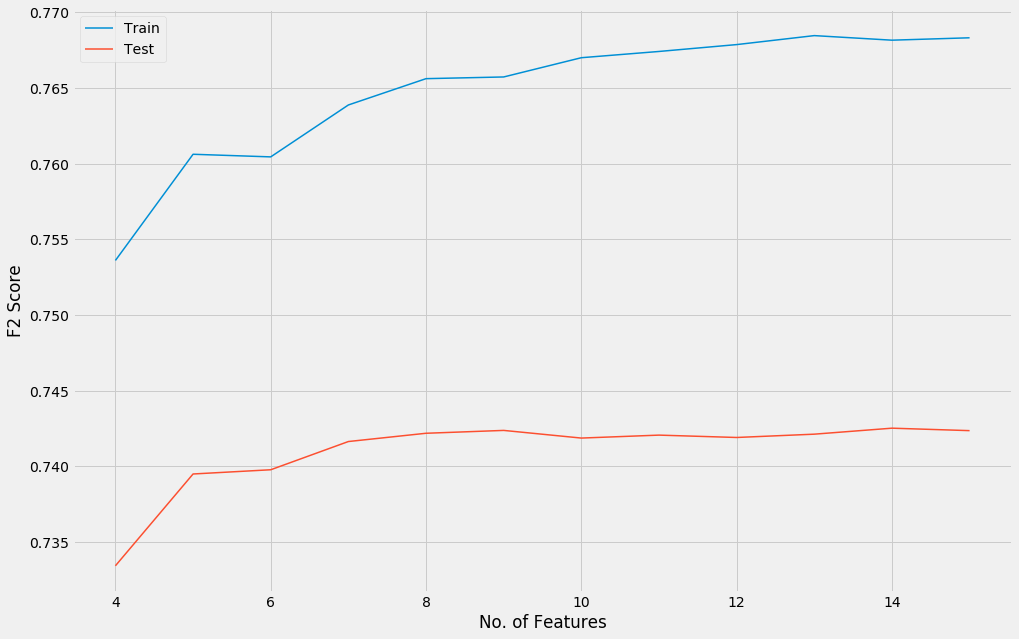

In [67]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(4,16,1), feat_train, lw=1.5, label='Train')
plt.plot(np.arange(4,16,1), feat_test, lw=1.5, label='Test')
plt.xlabel('No. of Features')
plt.ylabel('F2 Score')
plt.legend()

In [75]:
gb_trees = GradientBoostingClassifier(max_depth=10, max_features=9, random_state=42, n_iter_no_change=5, tol=.01)
trees_grid = {
    'n_estimators': np.arange(20, 220, 10)
}
tree_search = GridSearchCV(estimator = gb_trees, param_grid = trees_grid, scoring=ftwo_scorer, cv = skf, verbose = 2, return_train_score=True)

In [76]:
tree_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. n_estimators=20, total=  37.6s
[CV] n_estimators=20 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.4s remaining:    0.0s


[CV] .................................. n_estimators=20, total=  35.7s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=  34.1s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=  34.5s
[CV] n_estimators=20 .................................................
[CV] .................................. n_estimators=20, total=  45.8s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=  56.5s
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total= 1.1min
[CV] n_estimators=30 .................................................
[CV] .................................. n_estimators=30, total=  50.2s
[CV] n_estimators=30 .................................................
[CV] .

[CV] ................................. n_estimators=130, total= 1.3min
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total= 1.2min
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total= 1.2min
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total= 1.2min
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total= 1.1min
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=  59.6s
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=  55.0s
[CV] n_estimators=150 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 648.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_depth=10, max_features=9,
                                                  n_iter_no_change=5,
                                                  random_state=42, tol=0.01),
             param_grid={'n_estimators': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190, 200, 210])},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=2)

In [77]:
trees_train = tree_search.cv_results_['mean_train_score']
trees_test = tree_search.cv_results_['mean_test_score']

In [78]:
trees_test

array([0.72746061, 0.74006288, 0.74237475, 0.74237475, 0.74237475,
       0.74237475, 0.74237475, 0.74237475, 0.74237475, 0.74237475,
       0.74237475, 0.74237475, 0.74237475, 0.74237475, 0.74237475,
       0.74237475, 0.74237475, 0.74237475, 0.74237475, 0.74237475])

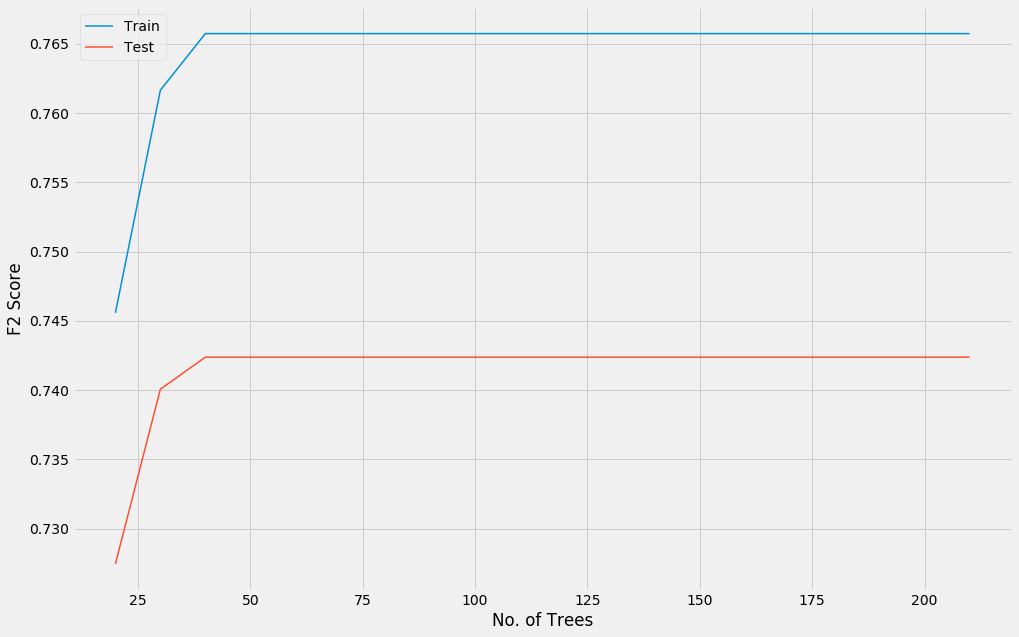

In [80]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(20, 220, 10), trees_train, lw=1.5, label='Train')
plt.plot(np.arange(20, 220, 10), trees_test, lw=1.5, label='Test')
plt.xlabel('No. of Trees')
plt.ylabel('F2 Score')
plt.legend()

In [81]:
gb_final = GradientBoostingClassifier(n_estimators=40, max_depth=10, max_features=9, random_state=42, n_iter_no_change=5, tol=.01)
gb_final.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, max_features=9, n_estimators=40,
                           n_iter_no_change=5, random_state=42, tol=0.01)

In [135]:
y_pred = gb_final.predict(X_test)

In [136]:
print(fbeta_score(y_test, y_pred, beta=2))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.7363672805072999
0.7259784782401676
0.7810763043979406


In [137]:
import itertools
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Blues):
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.xticks(range(0,2))
    plt.yticks(range(0,2))
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

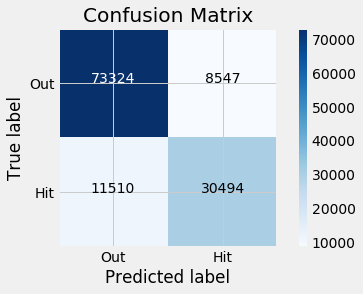

In [138]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,cmap=plt.cm.Blues)
plt.xticks([0,1], ['Out', 'Hit'])
plt.yticks([0,1], ['Out', 'Hit']);

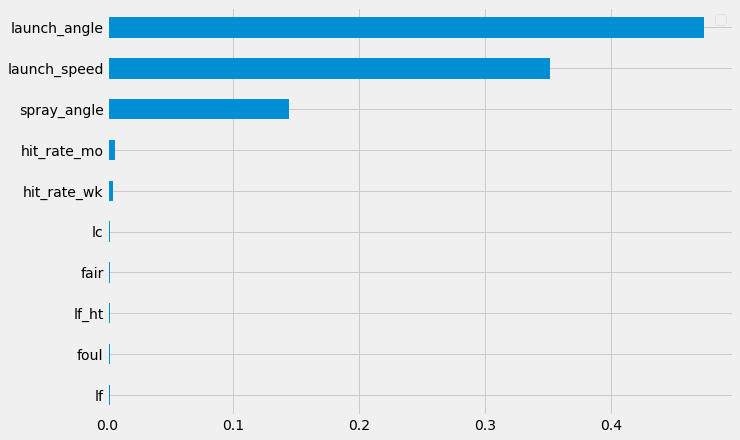

In [139]:
feat_imp = gb_final.feature_importances_
features = X_train.columns.values
zipped = zip(features, feat_imp)
zipped = [z for z in zipped if z[1] > 0]
feat_imp_sort = sorted(list(zipped), key=lambda tup: abs(tup[1]))[-10:]

feat_imp_df = pd.DataFrame.from_records(feat_imp_sort)
feat_imp_df.plot.barh(figsize=(10,7))
plt.legend([])
plt.yticks(range(0, len(feat_imp_df)), feat_imp_df[0]);

In [140]:
thresh = np.linspace(.05, .95, 91)
thresh

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
       0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37,
       0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48,
       0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
       0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95])

In [141]:
fbetas = {}
for thr in thresh:
    pred = [1 if y >= thr else 0 for y in gb_final.predict_proba(X_test)[:,1]]
    fbetas[thr] = fbeta_score(y_test, pred, beta=2)
    print(f'Done with threshold = {str(thr)}')

Done with threshold = 0.05
Done with threshold = 0.06
Done with threshold = 0.07
Done with threshold = 0.08
Done with threshold = 0.09
Done with threshold = 0.09999999999999999
Done with threshold = 0.10999999999999999
Done with threshold = 0.12
Done with threshold = 0.13
Done with threshold = 0.13999999999999999
Done with threshold = 0.14999999999999997
Done with threshold = 0.15999999999999998
Done with threshold = 0.16999999999999998
Done with threshold = 0.18
Done with threshold = 0.19
Done with threshold = 0.19999999999999996
Done with threshold = 0.20999999999999996
Done with threshold = 0.21999999999999997
Done with threshold = 0.22999999999999998
Done with threshold = 0.24
Done with threshold = 0.24999999999999994
Done with threshold = 0.25999999999999995
Done with threshold = 0.26999999999999996
Done with threshold = 0.27999999999999997
Done with threshold = 0.29
Done with threshold = 0.3
Done with threshold = 0.30999999999999994
Done with threshold = 0.31999999999999995
Done 

In [142]:
best_thr = max(fbetas, key=fbetas.get)
best_thr

0.16999999999999998

In [143]:
y_pred_thr = [1 if y >= best_thr else 0 for y in gb_final.predict_proba(X_test)[:,1]]

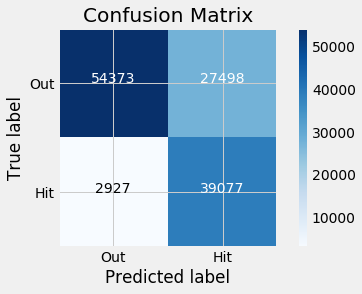

In [144]:
cm = confusion_matrix(y_test, y_pred_thr)
plot_confusion_matrix(cm,cmap=plt.cm.Blues)
plt.xticks([0,1], ['Out', 'Hit'])
plt.yticks([0,1], ['Out', 'Hit']);

In [145]:
print(fbeta_score(y_test, y_pred_thr, beta=2))
print(recall_score(y_test, y_pred_thr))
print(precision_score(y_test, y_pred_thr))

0.8328750889846585
0.9303161603656794
0.586962072850169


In [146]:
data_test = data_test.reset_index().drop(columns='index')

In [147]:
data_test['pred_thr_hit'] = y_pred_thr
data_test['pred_hit'] = y_pred

In [148]:
data_test.head(10)

,game_date,game_year,home_team,away_team,def_team,at_bat_number,events,launch_angle,launch_speed,spray_angle,...,lf,lc,cf,rc,rf,hit_rate_wk,hit_rate_mo,hit,pred_thr_hit,pred_hit
0,2019-03-28,2019,LAD,ARI,ARI,5,double,28.5,94.9,-22.208982,...,330,375,395,375,330,0.000000,0.000000,1,1,0
1,2019-03-28,2019,LAD,ARI,ARI,7,field_out,-24.6,48.4,-20.336267,...,330,375,395,375,330,1.000000,1.000000,0,0,0
2,2019-03-28,2019,LAD,ARI,ARI,8,field_out,-4.6,82.4,27.977480,...,330,375,395,375,330,0.500000,0.500000,0,0,0
3,2019-03-28,2019,LAD,ARI,ARI,10,field_out,-20.7,82.9,28.500541,...,330,375,395,375,330,0.333333,0.333333,0,0,0
4,2019-03-28,2019,LAD,ARI,ARI,14,field_out,0.9,111.4,-15.118108,...,330,375,395,375,330,0.250000,0.250000,0,1,0
5,2019-03-28,2019,LAD,ARI,ARI,15,single,0.8,102.5,-7.587612,...,330,375,395,375,330,0.200000,0.200000,1,1,0
6,2019-03-28,2019,LAD,ARI,ARI,16,sac_bunt,-39.0,41.0,23.503822,...,330,375,395,375,330,0.333333,0.333333,0,0,0
7,2019-03-28,2019,LAD,ARI,ARI,17,home_run,28.0,104.5,-0.368349,...,330,375,395,375,330,0.285714,0.285714,1,1,1
8,2019-03-28,2019,LAD,ARI,ARI,22,field_out,12.7,79.9,-31.328242,...,330,375,395,375,330,0.375000,0.375000,0,1,1
9,2019-03-28,2019,LAD,ARI,ARI,24,field_out,53.1,88.3,22.370970,...,330,375,395,375,330,0.333333,0.333333,0,0,0


In [149]:
with open('statcast_hit_predictions.pkl', 'wb') as p2:
    pickle.dump(data_test, p2)